# mercury transit: making a composite image
On May 9, 2016, Mercury made a 7.5 hour transit across the Sun. In this notebook, we will be making a composite image of Mercury's transit across the Sun using data from the Solar Dynamics Observatory's Helioseismic and Magnetic Imager (HMI) instrument.

First, we'll import some modules:

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, requests
import pandas as pd
from astropy.io import fits
from matplotlib.cm import register_cmap, cmap_d
from scipy import ndimage
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we'll do is define a color table exactly like the [SAO ds9 heat color table](http://nbviewer.jupyter.org/gist/adonath/c9a97d2f2d964ae7b9eb):

In [2]:
ds9heat = {'red': lambda v : np.interp(v, [0, 0.34, 1], [0, 1, 1]),
           'green': lambda v : np.interp(v, [0, 1], [0, 1]),
           'blue': lambda v : np.interp(v, [0, 0.65, 0.98, 1], [0, 0, 1, 1])}
register_cmap('ds9heat', data=ds9heat)

Then we'll grab the data. Normally we pull [continuum intensity data](http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.Ic_720s) from the JSOC database, but these continuum intensity data were specially created from level-1 filtergram data such that the cadence of the images capture Mercury's ingress and egress. For the purpose of a composite image, using these data is a purely aesthetic choice, and the following methodology (with slightly different thresholds) works for the nominal continuum intensity data as well.

In [3]:
url = 'http://jsoc.stanford.edu/data/events/Mercury_HMI_I/WholeSun/fits/'
response = urllib.urlopen(url)
times = response.read()
files = pd.read_html(times,skiprows=2)
list_of_files = np.array(files[0][1])
print "There are",len(list_of_files),"files."

There are 554 files.


The real difficulty in making a composite image is to capture the entire effect of Mercury as the scattered light around the planet creates a couple-pixel annulus with an intensity comparable to other regions of the Sun. To capture this effect, we follow a six-step procedure:

####Step 1:
After selecting all of the images that will go into our composite image (about every 20 minutes looks aesthetically pleasing), we subtract from each image a background image during which Mercury is not transiting the Sun. This differenced image (stored in variable `differenced_image`) is especially useful in eliminating the effect of limb darkening. We then set all pixels that are not within the transit path to zero.

####Step 2:
Then we apply a threshold to the differenced image to capture the pixels that correspond to Mercury. This requires some experiment: if we choose a threshold that is too high, we don't capture the entire planet. However, if we choose a threshold that is too low, we capture extraneous pixels. Therefore, we'll first apply a threshold that is too high -- to make sure we don't capture extraneous pixels -- and then generate a binary mask where the pixels labeled with a 1 represent the location of Mercury and the pixels labeled with a 0 represent the locations where Mercury does not exist (stored in variable `mask`). 

####Step 3:
Now, we'll compensate for the fact that we chose a low threshold: we'll use [morphological binary dilation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.morphology.binary_dilation.html) to grow the radius of Mercury within the mask by a few pixels (stored in variable `dilated_mask`).

####Step 4:
We can create a masked image by multiplying this dilated binary mask by the original image to get the value of the pixels at the locations of Mercury (stored in variable `masked_image`).

In [4]:
background = fits.open("http://jsoc.stanford.edu/data/events/Mercury_HMI_I/WholeSun/fits/20160509_185527_UTC.0554.fits")
background = background[1].data
mask_inverse = np.ones([4096,4096])
masked_image = np.zeros([4096,4096])
composite_dilated_mask = np.zeros([4096,4096])
for i in range(14,len(list_of_files),21):
    if (i == 539): 
        i = 540                                      # capture the egress
    mask = np.zeros([4096,4096])
    continuum = fits.open("http://jsoc.stanford.edu/data/events/Mercury_HMI_I/WholeSun/fits/"+list_of_files[i])
    continuum = continuum[1].data
    differenced_image = background - continuum
    differenced_image[0:1300,:] = 0.0                # mask out the area outside the transit path
    differenced_image[1500:4096,:] = 0.0
    find_mercury = np.where(differenced_image > 14000)
    for i in range(len(find_mercury[0])):
        mask[find_mercury[0][i],find_mercury[1][i]] = 1.
    dilated_mask = ndimage.binary_dilation(mask, iterations=2).astype(mask.dtype)
    composite_dilated_mask = composite_dilated_mask + dilated_mask
    masked_image = continuum*dilated_mask + masked_image

This is what each of these arrays look like within the transit path:

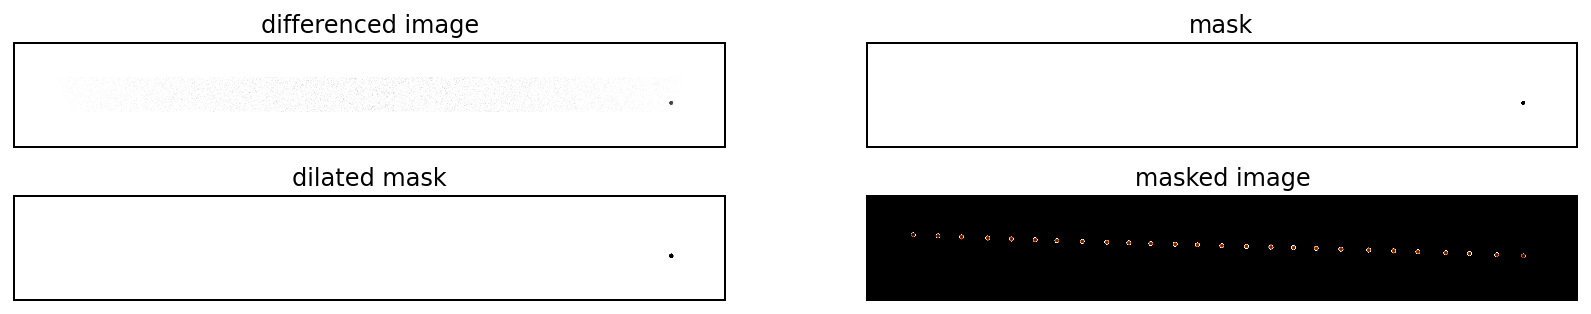

In [5]:
fig = plt.figure(figsize=(14,2.5))
ax = fig.add_subplot(2,2,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('differenced image')
plt.imshow(differenced_image[1100:1700,:],cmap='Greys',vmax=30000,vmin=0,origin='lower')
ax = fig.add_subplot(2,2,2)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('mask')
plt.imshow(mask[1100:1700,:],cmap='Greys',vmax=1.,vmin=0,origin='lower')
ax = fig.add_subplot(2,2,3)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('dilated mask')
plt.imshow(dilated_mask[1100:1700,:],cmap='Greys',vmax=1.,vmin=0,origin='lower')
ax = fig.add_subplot(2,2,4)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('masked image')
plt.imshow(masked_image[1100:1700,:],cmap='ds9heat',vmax=20000,vmin=0,origin='lower')

####Step 5:
We can then multiply the inverse of the dilated binary mask -- where the the pixels labeled with a 0 represent the location of Mercury and the pixels labeled with a 1 represent the locations where Mercury does not exist (stored in variable `inverse_dilated_mask`) -- with the background image to create a composite image (stored in variable `composite`) with holes where Mercury should be.

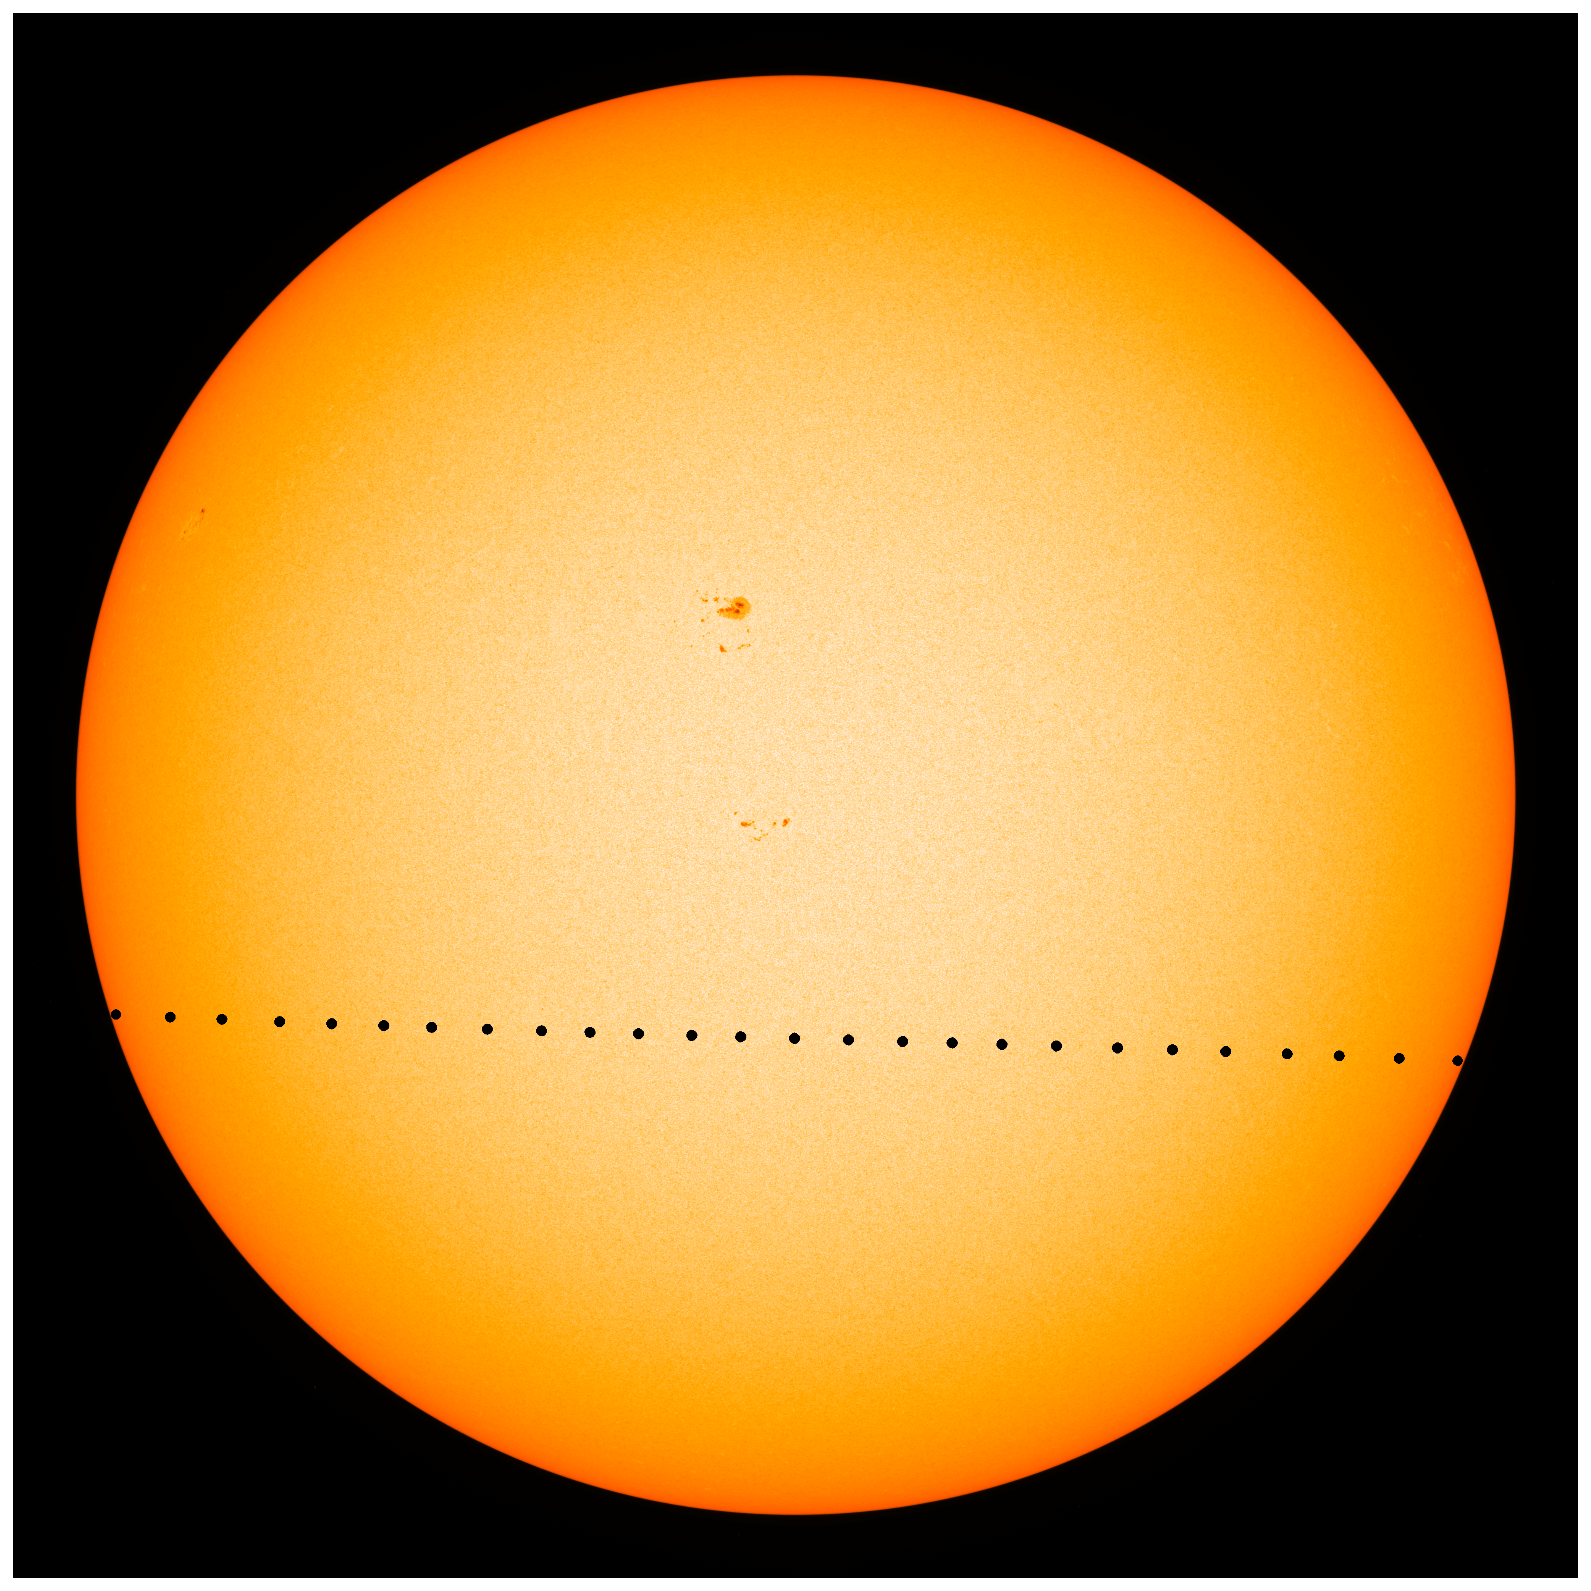

In [6]:
inverse_dilated_mask = np.logical_not(composite_dilated_mask).astype(composite_dilated_mask.dtype)
composite = background * inverse_dilated_mask
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(composite,cmap='ds9heat',vmax=62000,vmin=0,origin='lower')

####Step 6:
Finally, we can fill in these holes with the data by adding the composite image to the masked image.

In [7]:
final = composite + masked_image
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(final,cmap='ds9heat',vmax=np.nanmax(final),vmin=0,origin='lower')

Finally, save the figure at its native resolution (4096x4096 pixels):

In [8]:
%%capture
fsize = 4096.0/float(plt.rcParams['savefig.dpi'])
fig = plt.figure(figsize=(fsize,fsize))
ax = fig.add_subplot(1,1,1)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.imshow(final,cmap='ds9heat',vmax=np.nanmax(final),vmin=0,origin='lower',interpolation='nearest')
fig.savefig('mercury_composite.jpg')